In [1]:
# Author: Adib Fahimi
# Date: 2023-02-22

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import time
from PIL import Image
import os

In [2]:
# Importing the dataset
dataset = pd.read_csv('./data/mnist_train.csv')
X_train = dataset.iloc[:, 1:].values
y_train = dataset.iloc[:, 0].values

test = pd.read_csv('./data/mnist_test.csv')
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

# Normalize the input data
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1, 1)).toarray()


print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (60000, 784)
y_train shape:  (60000, 10)
X_test shape:  (10000, 784)
y_test shape:  (10000, 10)


In [3]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


class Model:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate=0.1):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.W1 = np.random.randn(
            input_size, hidden_size1) / np.sqrt(input_size)
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(
            hidden_size1, hidden_size2) / np.sqrt(hidden_size1)
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(
            hidden_size2, output_size) / np.sqrt(hidden_size2)
        self.b3 = np.zeros((1, output_size))
        self.enc = OneHotEncoder(handle_unknown='ignore')


    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = softmax(self.Z3)
        return self.A3

    def backward(self, X, y, y_hat):
        m = X.shape[0]
        dZ3 = y_hat - y
        dW3 = (1/m) * np.dot(self.A2.T, dZ3)
        db3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True)
        dZ2 = np.dot(dZ3, self.W3.T) * (self.A2 > 0)
        dW2 = (1/m) * np.dot(self.A1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        dZ1 = np.dot(dZ2, self.W2.T) * (self.A1 > 0)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        return dW1, db1, dW2, db2, dW3, db3

    def update(self, dW1, db1, dW2, db2, dW3, db3):
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

    def loss(self, y, y_hat):
        return -np.sum(y * np.log(y_hat + 1e-9)) / y.shape[0]

    def accuracy(self, y, y_hat):
        return np.mean(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))
    
    def train(self, X, y, epochs=10, batch_size=32):
        m = X.shape[0]
        for epoch in range(epochs):
            start = time.time()
            for i in range(0, m, batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_hat = self.forward(X_batch)
                dW1, db1, dW2, db2, dW3, db3 = self.backward(
                    X_batch, y_batch, y_hat)
                self.update(dW1, db1, dW2, db2, dW3, db3)
            y_hat = self.forward(X)
            loss = self.loss(y, y_hat)
            acc = self.accuracy(y, y_hat)
            print("Epoch: {}, loss: {:.4f}, acc: {:.4f}, time: {:.4f}".format(
                epoch+1, loss, acc, time.time()-start))
        
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

    def save(self):
        np.save('./model/W1.npy', self.W1)
        np.save('./model/b1.npy', self.b1)
        np.save('./model/W2.npy', self.W2)
        np.save('./model/b2.npy', self.b2)
        np.save('./model/W3.npy', self.W3)
        np.save('./model/b3.npy', self.b3)

    def load(self):
        self.W1 = np.load('./model/W1.npy')
        self.b1 = np.load('./model/b1.npy')
        self.W2 = np.load('./model/W2.npy')
        self.b2 = np.load('./model/b2.npy')
        self.W3 = np.load('./model/W3.npy')
        self.b3 = np.load('./model/b3.npy')


In [4]:
input_size = 784
hidden_size1 = 256
hidden_size2 = 128
output_size = 10

model = Model(input_size, hidden_size1, hidden_size2,
              output_size, learning_rate=0.1)

# model.train(X_train, y_train, epochs=10, batch_size=32)
# model.save()
model.load()

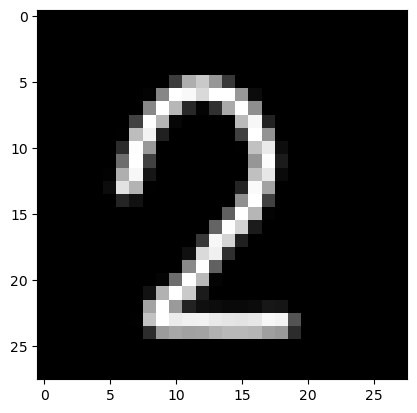

2


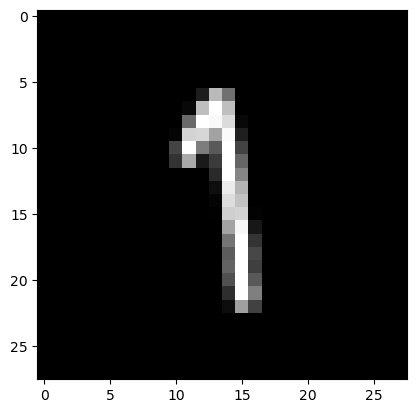

1


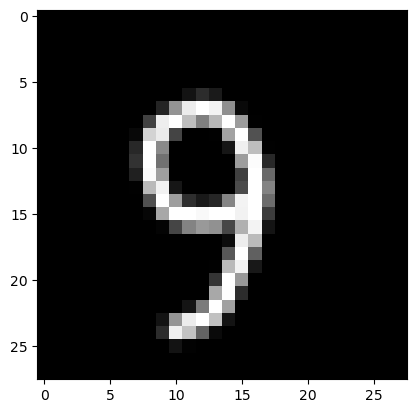

9


In [5]:
# test on images
files = os.listdir('images')

for _ in files:
    img = Image.open('./images/' + _).convert('L')
    img = img.resize((28, 28))
    img = np.array(img)
    plt.imshow(img, cmap='gray')
    plt.show()
    img = img.reshape(1, -1)
    img = img / 255.0

    print(model.predict(img)[0])